In [7]:
%load_ext autoreload
%autoreload 3 --print

In [97]:
import torch as th
import numpy as np
from torch import optim
from torch import nn
from dynrn.rnntasks import SimpleTasks
from dynrn.viz import util as vu
import matplotlib.pyplot as plt
from pathlib import Path
import tqdm
import seaborn as sns

In [9]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
from dynrn.viz import styles
colors, plotter = styles.init_plt(
    '../plots/notebook/rnn-run',
    fmt = 'pdf')
plot_root = Path(plotter.plot_dir)

In [90]:
def at(inds, axis=-1, slc=(slice(None),)): 
    """np.take for assignment"""
    return (axis<0)*(Ellipsis,) + axis*slc + (inds,) + (-1-axis)*slc 

def expsums(x, gamma, axis = -1):
    """
    r3 = x3
    r2 = x2 + g x3 = x2 + g r3
    r1 = g x1 + g^2 x2 + g^3 x3 = x + g r2"""
    x = np.asarray(x)
    gamma = float(gamma)
    ret = np.zeros_like(x)
    n = x.shape[axis]
    r_iplusone = 0
    for i in range(n-1, -1, -1):
        xi = np.take(x, i, axis = axis)
        ret[at(i, axis)] = xi + gamma * r_iplusone
        r_iplusone = np.take(ret, i, axis = axis)
    return ret

def eligibilities(x, r, axis = -1):
    reverse = at(slice(None, None, -1), axis = axis)
    return expsums(x[reverse], r, axis)[reverse]



In [99]:
x, y, s = SimpleTasks.fixed_interval(
    interval = 4, iti_halflife = 5, iti_min = 5, session_length = 180, n_sessions = 100, n_dim = 2, states = True
)
ndim = x.shape[-1]
nstates = s.shape[-1]
x = th.tensor(x, dtype=th.float32)
y = th.tensor(y, dtype=th.float32)

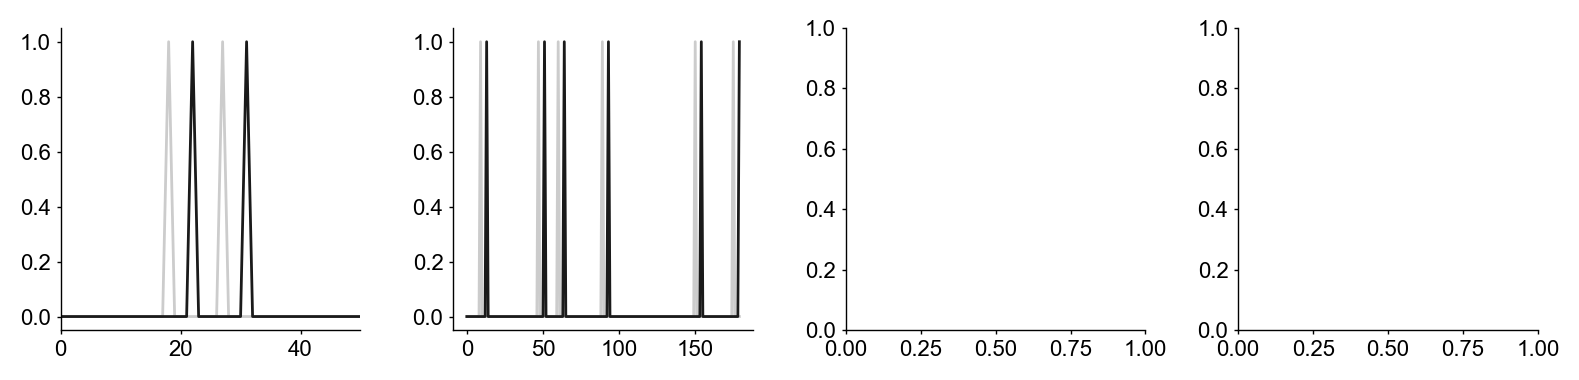

In [65]:
fig, ax = plt.subplots(1, 4, figsize=(8, 2))
for i in range(x.shape[-1]):
    ax[i].plot(x.numpy()[0, :, i], color = colors.subtle)
    ax[i].plot(y.numpy()[0, :, i], color = colors.neutral)
ax[0].set_xlim(0, 50)
plotter.finalize(fig, None)

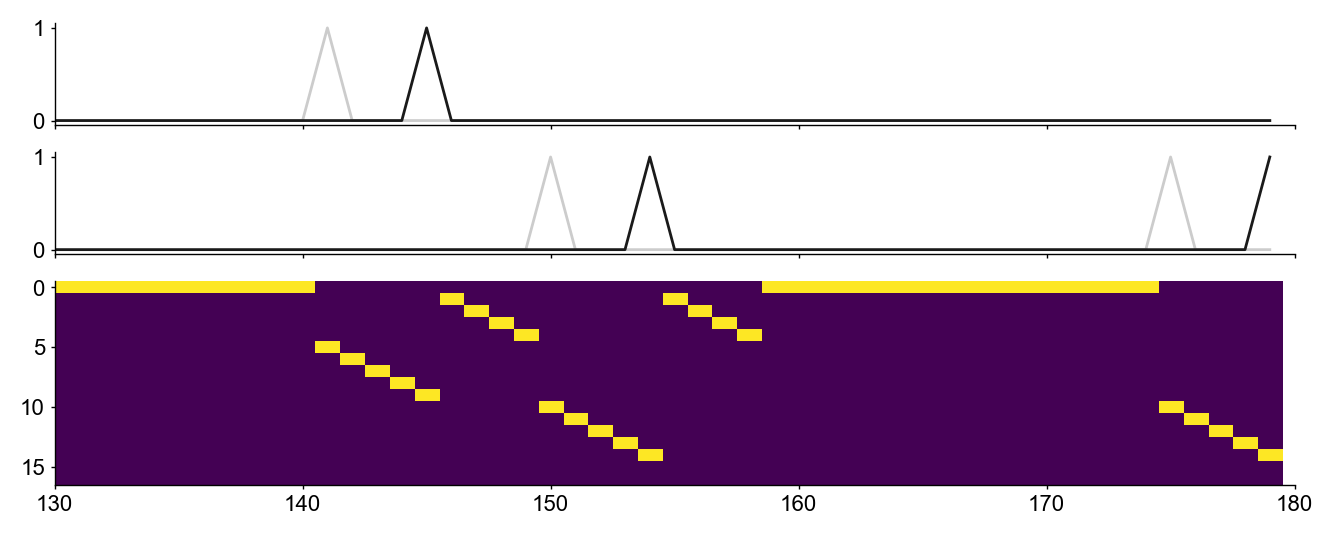

In [73]:
fig, ax = plt.subplots(ndim + 1, figsize=(8, 3), sharex = True, height_ratios=[1, 1, 2])
for i in range(x.shape[-1]):
    ax[i].plot(x.numpy()[0, :, i], color = colors.subtle)
    ax[i].plot(y.numpy()[0, :, i], color = colors.neutral)
ax[0].set_xlim(130, 180)
_ = ax[2].imshow(s[0].T, aspect='auto', interpolation = 'nearest')

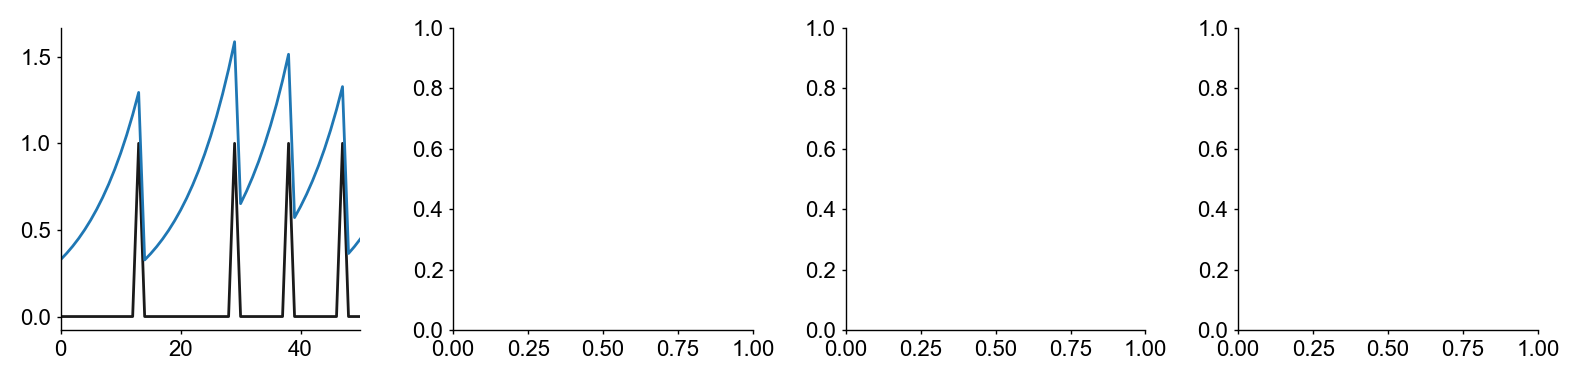

In [27]:
ysum = expsums(y.numpy(), 0.9, axis = 1)
ysum = th.tensor(ysum, dtype=th.float32)

fig, ax = plt.subplots(1, 4, figsize=(8, 2))
for i in range(x.shape[-1]):
    ax[i].plot(y.numpy()[0, :, i], color = colors.neutral)
    ax[i].plot(ysum.numpy()[0, :, i], color = colors.C[0])
ax[0].set_xlim(0, 50)
plotter.finalize(fig, None)

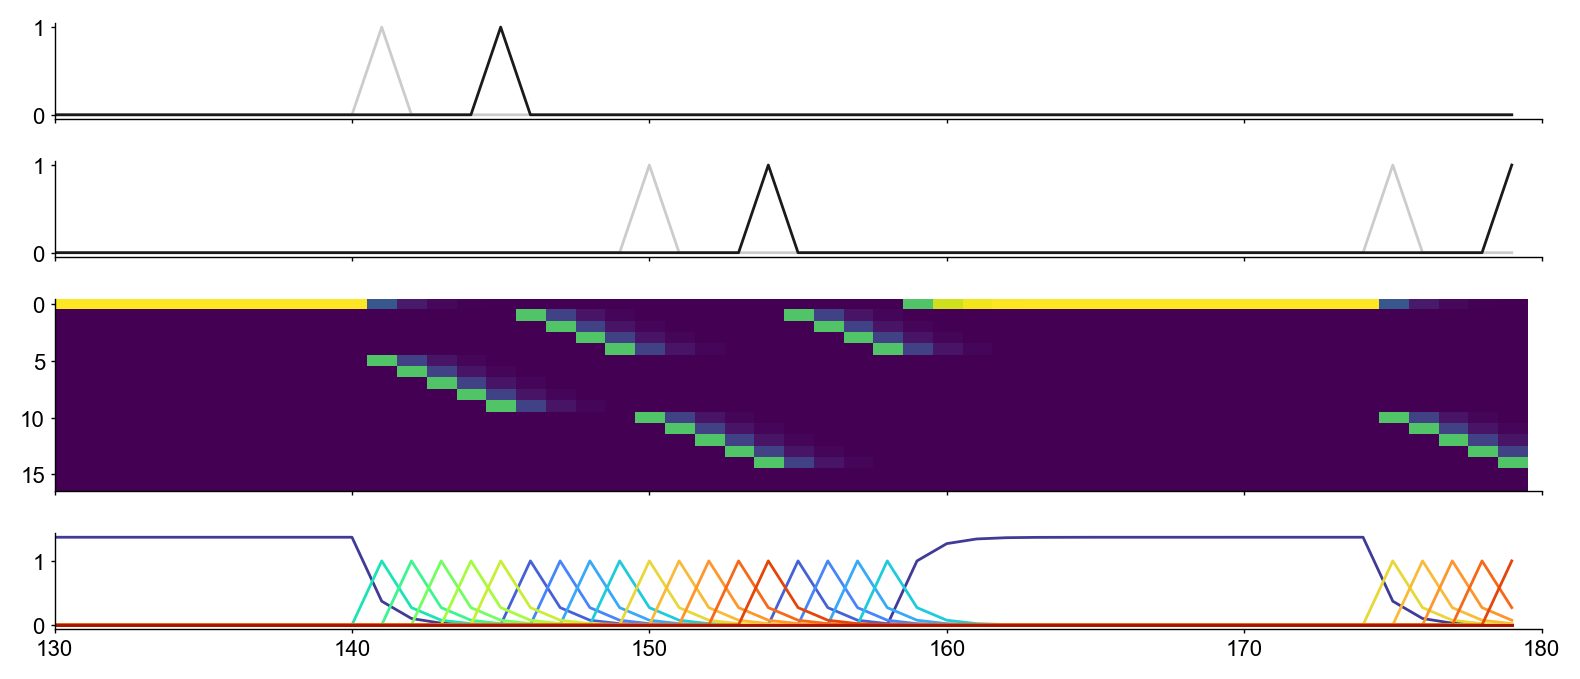

In [101]:
gamma = 0.9
lambd = 0.3
e = eligibilities(s, gamma * lambd, axis = 1)

fig, ax = plt.subplots(ndim + 2, figsize=(8, 3.5), sharex = True, height_ratios=[1, 1, 2, 1])
for i in range(x.shape[-1]):
    ax[i].plot(x.numpy()[0, :, i], color = colors.subtle)
    ax[i].plot(y.numpy()[0, :, i], color = colors.neutral)
ax[0].set_xlim(130, 180)
_ = ax[2].imshow(e[0].T, aspect='auto', interpolation = 'nearest')
for i, c in enumerate(sns.color_palette('turbo', nstates)):
    ax[3].plot(e[0, :, i], color = c)
plotter.finalize(fig, None)
    

In [160]:
V = th.zeros(nstates)
r = y[..., 0] # only call the first output dimension reward
lr = 1e-4
n_steps = 100

si = th.tensor(np.argmax(s, axis = -1), dtype=th.long)
e_ = th.tensor(np.ascontiguousarray(e[..., :-1, :]), dtype=th.float)

V_hist = []
err_hist = []
upd_hist = []
for i in range(n_steps):
    td_err = r[..., 1:] + gamma * V[si[..., 1:]] - V[si[..., :-1]]
    td_upd = e_ * td_err[..., None]

    V_hist.append(V.numpy())
    err_hist.append(td_err.numpy())
    upd_hist.append(td_upd.numpy())
    
    V = V + lr * td_upd.sum(axis = (0, 1))

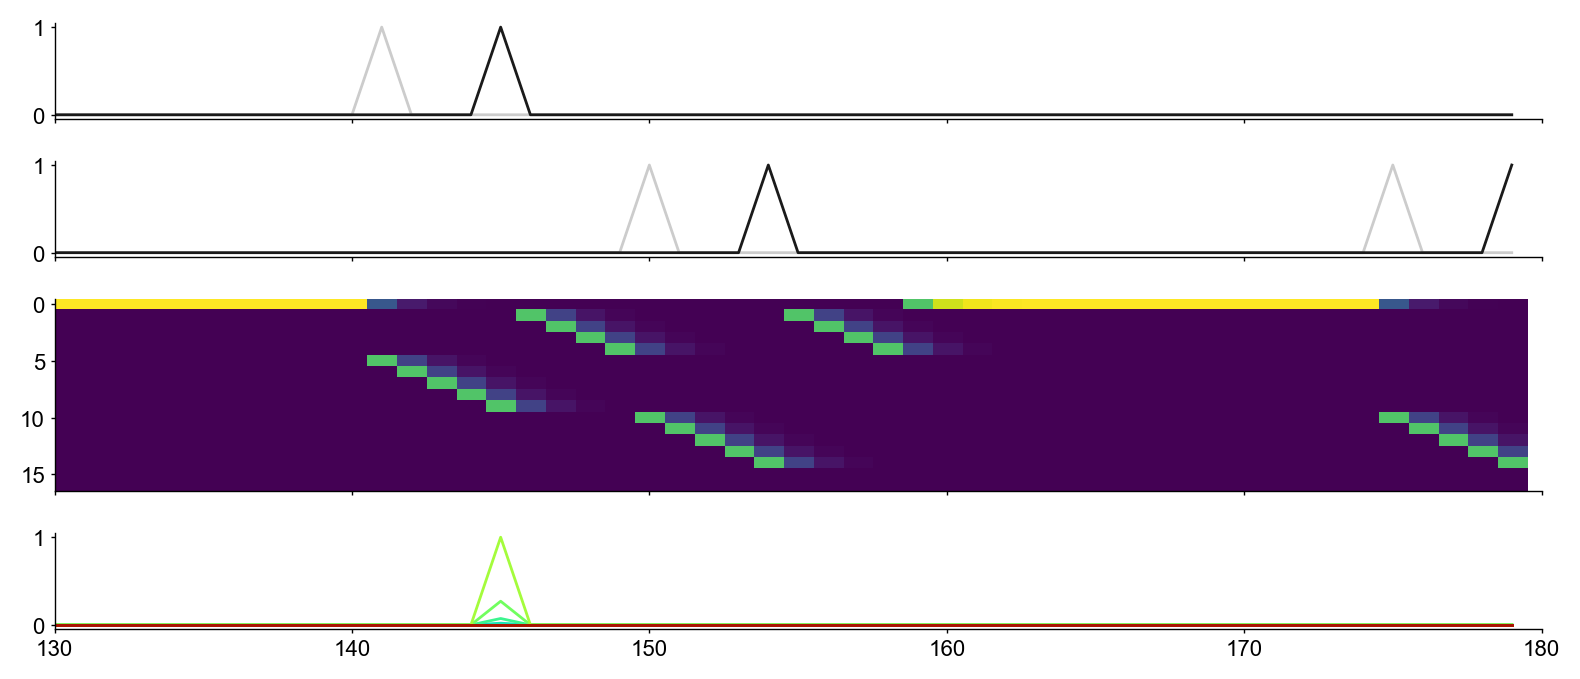

In [161]:
fig, ax = plt.subplots(ndim + 2, figsize=(8, 3.5), sharex = True, height_ratios=[1, 1, 2, 1])
for i in range(x.shape[-1]):
    ax[i].plot(x.numpy()[0, :, i], color = colors.subtle)
    ax[i].plot(y.numpy()[0, :, i], color = colors.neutral)
ax[0].set_xlim(130, 180)
_ = ax[2].imshow(e[0].T, aspect='auto', interpolation = 'nearest')
for i, c in enumerate(sns.color_palette('turbo', nstates)):
    ax[3].plot(np.arange(1, x.shape[1]), upd_hist[0][0, :, i], color = c)
plotter.finalize(fig, None)

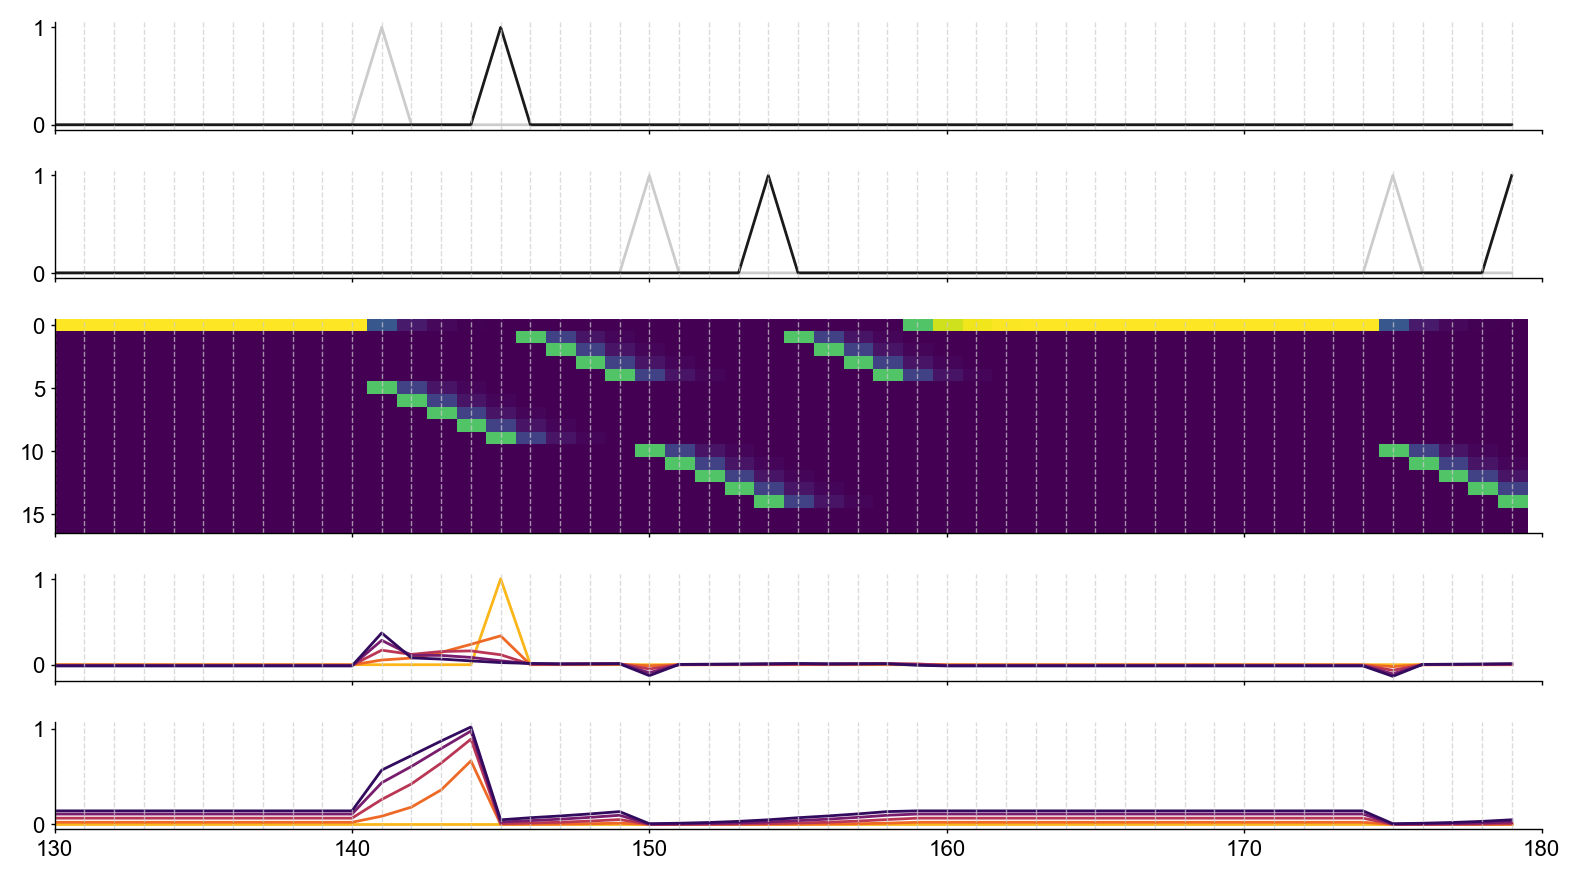

In [164]:
fig, ax = plt.subplots(ndim + 3, figsize=(8, 4.5), sharex = True, height_ratios=[1, 1, 2, 1, 1])
skip = 20
session = 0
for i in range(x.shape[-1]):
    ax[i].plot(x.numpy()[session, :, i], color = colors.subtle)
    ax[i].plot(y.numpy()[session, :, i], color = colors.neutral)
ax[0].set_xlim(130, 180)
_ = ax[2].imshow(e[session].T, aspect='auto', interpolation = 'nearest')

for i, c in zip(np.arange(0, n_steps, skip), sns.color_palette('inferno_r', n_steps // skip)):
    ax[3].plot(np.arange(1, x.shape[1]), err_hist[i][session, :], color = c)
    ax[4].plot(V_hist[i][si[session]], color = c)

for i in range(x.shape[1]):
    for a in ax:
        a.axvline(i, color = colors.subtle, lw = 0.5, ls = '--', alpha = 0.7)
    
plotter.finalize(fig, None)